In [32]:
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession

config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

/usr/local/lib/python3.6/dist-packages/tensorflow_core/python/client/session.py:1750: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


In [63]:
# Let's install tensorflow 2.x first :)
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass

In [114]:
import csv
import os
import io
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [115]:
try:
  from google.colab import files
  BASE_PATH = "/content"
except Exception:
  BASE_PATH = "/home/$(whoami)/data/"

In [116]:
DATASET_NAME = "bbc-text.csv"
DATASET_URL = "https://storage.googleapis.com/laurencemoroney-blog.appspot.com"
DATASET_STORE = "./datasets"

In [117]:
!mkdir $DATASET_STORE

mkdir: cannot create directory ‘./datasets’: File exists


In [118]:
!ls $BASE_PATH

README.md    certificates	intro_to_tensorflow  rps-test-set.zip  scripts
cats-v-dogs  cnn_in_tensorflow	nlp_in_tensorflow    rps.zip	       tmp


In [119]:
!wget --no-check-certificate $DATASET_URL/$DATASET_NAME -O $DATASET_STORE/$DATASET_NAME

--2019-11-30 23:02:45--  https://storage.googleapis.com/laurencemoroney-blog.appspot.com/bbc-text.csv
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.193.128, 2a00:1450:400b:c01::80
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.193.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5057493 (4.8M) [application/octet-stream]
Saving to: ‘./datasets/bbc-text.csv’

./datasets/bbc-text 100%[===================>]   4.82M  18.7MB/s    in 0.3s    

2019-11-30 23:02:46 (18.7 MB/s) - ‘./datasets/bbc-text.csv’ saved [5057493/5057493]



In [120]:
sentences = []
labels = []
# Stopwords list from https://github.com/Yoast/YoastSEO.js/blob/develop/src/config/stopwords.js
stopwords = [ "a", "about", "above", "after", "again", "against", "all", "am", "an", "and", "any", 
             "are", "as", "at", "be", "because", "been", "before", "being", "below", "between", 
             "both", "but", "by", "could", "did", "do", "does", "doing", "down", "during", "each", 
             "few", "for", "from", "further", "had", "has", "have", "having", "he", "he'd", 
             "he'll", "he's", "her", "here", "here's", "hers", "herself", "him", "himself", 
             "his", "how", "how's", "i", "i'd", "i'll", "i'm", "i've", "if", "in", "into", 
             "is", "it", "it's", "its", "itself", "let's", "me", "more", "most", "my", "myself", 
             "nor", "of", "on", "once", "only", "or", "other", "ought", "our", "ours", "ourselves", 
             "out", "over", "own", "same", "she", "she'd", "she'll", "she's", "should", "so", "some", 
             "such", "than", "that", "that's", "the", "their", "theirs", "them", "themselves", "then", 
             "there", "there's", "these", "they", "they'd", "they'll", "they're", "they've", "this", "those", 
             "through", "to", "too", "under", "until", "up", "very", "was", "we", "we'd", "we'll", "we're", 
             "we've", "were", "what", "what's", "when", "when's", "where", "where's", "which", "while", "who", 
             "who's", "whom", "why", "why's", "with", "would", "you", "you'd", "you'll", "you're", "you've", 
             "your", "yours", "yourself", "yourselves" ]

print(len(stopwords))
# Expected Output
# 153

153


In [121]:
stored_file = os.path.join(DATASET_STORE,DATASET_NAME)

# Read the csv as a dataframe 
bbc_dataframe = pd.read_csv(stored_file, header=0)    

# Checkout how our content looks like 
bbc_dataframe.head()

,category,text
0,tech,tv future in the hands of viewers with home th...
1,business,worldcom boss left books alone former worldc...
2,sport,tigers wary of farrell gamble leicester say ...
3,sport,yeading face newcastle in fa cup premiership s...
4,entertainment,ocean s twelve raids box office ocean s twelve...


In [145]:
#Get vocab size 
unique_words = list(bbc_dataframe['text'].str.split(' ', expand=True).stack().unique())
len(unique_words)

43652

In [146]:
# Remove stop words from the dataset :) 
bbc_dataframe['text'] = bbc_dataframe['text'].apply(lambda x: ' '.join([item for item in x.split() if item not in stopwords]))

In [147]:
# Define the text and category as lists 
sentences = list(bbc_dataframe.text)
labels = list(bbc_dataframe.category)

In [148]:
print("Total amount of sentences: {}".format(len(sentences)))
print("Total amount of labels: {}".format(len(labels)))
print("First 100 chars: {}".format(sentences[0][:100]))
print("This sentence category: {}".format(labels[0]))

# Expected Output
# 2225
# 2225
# tv future hands viewers home theatre systems  plasma high-definition tvs  digital video recorders moving living room  way people watch tv will radically different five years  time.  according expert panel gathered annual consumer electronics show las vegas discuss new technologies will impact one favourite pastimes. us leading trend  programmes content will delivered viewers via home networks  cable  satellite  telecoms companies  broadband service providers front rooms portable devices.  one talked-about technologies ces digital personal video recorders (dvr pvr). set-top boxes  like us s tivo uk s sky+ system  allow people record  store  play  pause forward wind tv programmes want.  essentially  technology allows much personalised tv. also built-in high-definition tv sets  big business japan us  slower take off europe lack high-definition programming. not can people forward wind adverts  can also forget abiding network channel schedules  putting together a-la-carte entertainment. us networks cable satellite companies worried means terms advertising revenues well  brand identity  viewer loyalty channels. although us leads technology moment  also concern raised europe  particularly growing uptake services like sky+.  happens today  will see nine months years  time uk   adam hume  bbc broadcast s futurologist told bbc news website. likes bbc  no issues lost advertising revenue yet. pressing issue moment commercial uk broadcasters  brand loyalty important everyone.  will talking content brands rather network brands   said tim hanlon  brand communications firm starcom mediavest.  reality broadband connections  anybody can producer content.  added:  challenge now hard promote programme much choice.   means  said stacey jolna  senior vice president tv guide tv group  way people find content want watch simplified tv viewers. means networks  us terms  channels take leaf google s book search engine future  instead scheduler help people find want watch. kind channel model might work younger ipod generation used taking control gadgets play them. might not suit everyone  panel recognised. older generations comfortable familiar schedules channel brands know getting. perhaps not want much choice put hands  mr hanlon suggested.  end  kids just diapers pushing buttons already - everything possible available   said mr hanlon.  ultimately  consumer will tell market want.   50 000 new gadgets technologies showcased ces  many enhancing tv-watching experience. high-definition tv sets everywhere many new models lcd (liquid crystal display) tvs launched dvr capability built  instead external boxes. one example launched show humax s 26-inch lcd tv 80-hour tivo dvr dvd recorder. one us s biggest satellite tv companies  directtv  even launched branded dvr show 100-hours recording capability  instant replay  search function. set can pause rewind tv 90 hours. microsoft chief bill gates announced pre-show keynote speech partnership tivo  called tivotogo  means people can play recorded programmes windows pcs mobile devices. reflect increasing trend freeing multimedia people can watch want  want.

Total amount of sentences: 2225
Total amount of labels: 2225
First 100 chars: tv future hands viewers home theatre systems plasma high-definition tvs digital video recorders movi
This sentence category: tech


In [213]:
VOCAB_SIZE = 5000
EMBEDDING_DIM = 32
MAX_LENGTH = 200
TRUNC_TYPE = 'post'
PADDING_TYPE = 'post'
OOV_TOKEN = "<oov>"
TRAINING_PORTION = .8

In [214]:
train_size = int(len(sentences) * TRAINING_PORTION)
train_size

1780

In [215]:
# Split the data between training and validation
train_sentences, validation_sentences = sentences[0:train_size], sentences[train_size:]
train_labels, validation_labels = labels[0:train_size], labels[train_size:]

In [216]:
# Build the Tokenizer with the training sequences
tokenizer = Tokenizer(num_words=VOCAB_SIZE, oov_token=OOV_TOKEN)

# Encode the training sentences 
tokenizer.fit_on_texts(train_sentences)

#Get the word_index
word_index = tokenizer.word_index

In [217]:
# Get the sequences
train_sequences = tokenizer.texts_to_sequences(train_sentences)

# Get the padded sequences
train_padded = pad_sequences(sequences=train_sequences, maxlen=MAX_LENGTH,
                             padding=PADDING_TYPE, truncating=TRUNC_TYPE)

In [218]:
print("Size of train seq 0:{}".format(len(train_sequences[0])))
print("Size of train padded 0:{}".format(len(train_padded[0])))

print("Size of train seq 1:{}".format(len(train_sequences[1])))
print("Size of train padded 1:{}".format(len(train_padded[1])))

print("Size of train seq 10:{}".format(len(train_sequences[10])))
print("Size of train padded 10:{}".format(len(train_padded[10])))

# Expected Ouput
# 449
# 120
# 200
# 120
# 192
# 120

Size of train seq 0:449
Size of train padded 0:200
Size of train seq 1:200
Size of train padded 1:200
Size of train seq 10:192
Size of train padded 10:200


In [219]:
# Generate sequences for validation sentences
validation_sequences = tokenizer.texts_to_sequences(validation_sentences)

# Get validation padded 
validation_padded = pad_sequences(sequences=validation_sequences, maxlen=MAX_LENGTH,
                             padding=PADDING_TYPE, truncating=TRUNC_TYPE)

print(len(validation_sequences))
print(validation_padded.shape)

# Expected output
# 445
# (445, 120)

445
(445, 200)


In [220]:
# Create a Label Tokenizer 
label_tokenizer = Tokenizer()

# Encode the labels 
label_tokenizer.fit_on_texts(train_labels)

num_classes = len(label_tokenizer.word_index)

In [237]:
label_tokenizer.word_index

{'sport': 1, 'business': 2, 'politics': 3, 'entertainment': 4, 'tech': 5}

In [221]:
# Generate the sequences for the labels 
training_label_seq = np.array(label_tokenizer.texts_to_sequences(train_labels))
# Generate the sequences for validation labels 
validation_label_seq = np.array(label_tokenizer.texts_to_sequences(validation_labels))

In [222]:
print(training_label_seq[0])
print(training_label_seq[1])
print(training_label_seq[2])
print(training_label_seq.shape)

print(validation_label_seq[0])
print(validation_label_seq[1])
print(validation_label_seq[2])
print(validation_label_seq.shape)

# Expected output
# [4]
# [2]
# [1]
# (1780, 1)
# [5]
# [4]
# [3]
# (445, 1)

[5]
[2]
[1]
(1780, 1)
[4]
[5]
[3]
(445, 1)


In [223]:
# Define the model 
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(input_dim=VOCAB_SIZE, output_dim=EMBEDDING_DIM, input_length=MAX_LENGTH),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(24, activation='relu'),
    tf.keras.layers.Dense(6, activation='sigmoid')
])

In [224]:
# Configure the model 
model.compile(loss='sparse_categorical_crossentropy',optimizer='adam',metrics=['accuracy'])
model.summary()

# Expected Output
# Layer (type)                 Output Shape              Param #   
# =================================================================
# embedding (Embedding)        (None, 120, 16)           16000     
# _________________________________________________________________
# global_average_pooling1d (Gl (None, 16)                0         
# _________________________________________________________________
# dense (Dense)                (None, 24)                408       
# _________________________________________________________________
# dense_1 (Dense)              (None, 6)                 150       
# =================================================================
# Total params: 16,558
# Trainable params: 16,558
# Non-trainable params: 0

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_10 (Embedding)     (None, 200, 32)           160000    
_________________________________________________________________
global_average_pooling1d_10  (None, 32)                0         
_________________________________________________________________
dense_20 (Dense)             (None, 24)                792       
_________________________________________________________________
dense_21 (Dense)             (None, 6)                 150       
Total params: 160,942
Trainable params: 160,942
Non-trainable params: 0
_________________________________________________________________


In [225]:
num_epochs = 50

# Train the model 
history = model.fit(train_padded, 
                    training_label_seq, 
                    epochs=num_epochs, 
                    validation_data=(validation_padded, validation_label_seq), 
                    verbose=2)

Train on 1780 samples, validate on 445 samples
Epoch 1/50
1780/1780 - 1s - loss: 1.7700 - accuracy: 0.3927 - val_loss: 1.7357 - val_accuracy: 0.4382
Epoch 2/50
1780/1780 - 0s - loss: 1.6750 - accuracy: 0.4826 - val_loss: 1.5923 - val_accuracy: 0.5236
Epoch 3/50
1780/1780 - 0s - loss: 1.4740 - accuracy: 0.5556 - val_loss: 1.3529 - val_accuracy: 0.5843
Epoch 4/50
1780/1780 - 0s - loss: 1.1904 - accuracy: 0.7118 - val_loss: 1.0610 - val_accuracy: 0.7978
Epoch 5/50
1780/1780 - 0s - loss: 0.8578 - accuracy: 0.8972 - val_loss: 0.7358 - val_accuracy: 0.8854
Epoch 6/50
1780/1780 - 0s - loss: 0.5359 - accuracy: 0.9511 - val_loss: 0.4805 - val_accuracy: 0.9326
Epoch 7/50
1780/1780 - 0s - loss: 0.3247 - accuracy: 0.9702 - val_loss: 0.3400 - val_accuracy: 0.9483
Epoch 8/50
1780/1780 - 0s - loss: 0.2141 - accuracy: 0.9820 - val_loss: 0.2672 - val_accuracy: 0.9573
Epoch 9/50
1780/1780 - 0s - loss: 0.1503 - accuracy: 0.9893 - val_loss: 0.2174 - val_accuracy: 0.9596
Epoch 10/50
1780/1780 - 0s - loss: 

In [227]:
def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()
  

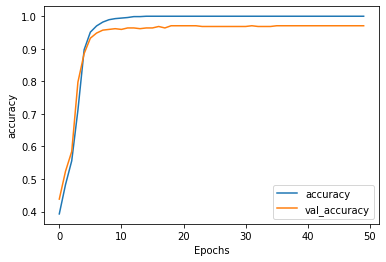

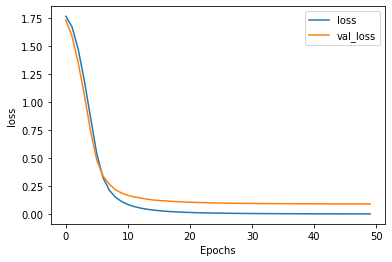

In [228]:
plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

In [229]:
reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])

def decode_sentence(text):
    return ' '.join([reverse_word_index.get(i, '?') for i in text])


In [230]:
e = model.layers[0]
weights = e.get_weights()[0]
print(weights.shape) # shape: (vocab_size, embedding_dim)

# Expected output
# (1000, 16)

(5000, 32)


In [231]:
vecs_file = "vecs_bbc.tsv"
meta_file = "meta_bbc.tsv"

vec_path = os.path.join(DATASET_STORE, vecs_file)
meta_path = os.path.join(DATASET_STORE, meta_file)

In [235]:
out_v = io.open(vec_path, 'w', encoding='utf-8')
out_m = io.open(meta_path, 'w', encoding='utf-8')

In [236]:
for word_num in range(1, VOCAB_SIZE):
  word = reverse_word_index[word_num]
  embeddings = weights[word_num]
  out_m.write(word + "\n")
  out_v.write('\t'.join([str(x) for x in embeddings]) + "\n")
out_v.close()
out_m.close()

In [0]:
try:
  from google.colab import files
except ImportError:
  pass
else:
  files.download('vecs.tsv')
  files.download('meta.tsv')

In [241]:
sentence = ["By-elections 2019: Taoiseach dealt setback as Fine Gael fails to win any Dáil seats - but good day for Green's, Fianna Fáil and Sinn Féin", 
            "When Professor Akira Yoshino was developing a new battery technology in his laboratory in the early 1980s, he didn't think it would amount to much.",
           "A new technology has been created by Microsoft",
           "The scariest movie ever has been released to the public"]
sequences = tokenizer.texts_to_sequences(sentence)
padded = pad_sequences(sequences, maxlen=MAX_LENGTH, padding=PADDING_TYPE, truncating=TRUNC_TYPE)
print(model.predict(padded))

[[0.0000000e+00 8.2075596e-05 2.8312206e-05 8.3446503e-07 1.6868114e-05
  3.8743019e-07]
 [0.0000000e+00 8.4370375e-05 2.5391579e-05 1.1622906e-06 1.6450882e-05
  6.2584877e-07]
 [0.0000000e+00 1.3577938e-04 4.2587519e-05 1.0132790e-06 1.6689301e-05
  3.2782555e-07]
 [0.0000000e+00 1.0454655e-04 2.8192997e-05 1.5199184e-06 3.0010939e-05
  2.9802322e-07]]


In [ ]:
# {'sport': 1, 'business': 2, 'politics': 3, 'entertainment': 4, 'tech': 5}